# Email Spam Classification

In [43]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("data.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

### Handling Imbalanced Data

In [7]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [9]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [11]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [15]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [17]:
df_balanced = pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [18]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [20]:
df_balanced.sample(5)

,Category,Message
533,ham,Gudnite....tc...practice going on
2271,ham,U know we watchin at lido?
5199,ham,Ugh my leg hurts. Musta overdid it on mon.
203,ham,Your account has been refilled successfully by...
4717,ham,Hey. What happened? U switch off ur cell d who...


In [22]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
3442,spam,Get a FREE mobile video player FREE movie. To ...,1
2367,spam,Tone Club: Your subs has now expired 2 re-sub ...,1
967,ham,I am not sure about night menu. . . I know onl...,0
1482,ham,"I'm a guy, browsin is compulsory",0
1820,ham,Dunno dat's wat he told me. Ok lor...,0
1564,ham,Get ready to put on your excellent sub face :),0
707,ham,So when do you wanna gym harri,0
34,spam,Thanks for your subscription to Ringtone UK yo...,1
349,spam,Fancy a shag? I do.Interested? sextextuk.com t...,1
3621,ham,I meant as an apology from me for texting you ...,0


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [25]:
X_train.head()

1909    Hello beautiful r u ok? I've kinda ad a row wi...
5349                                          I'm home...
4159    It certainly puts things into perspective when...
5030    I'd like to tell you my deepest darkest fantas...
1048    1000's flirting NOW! Txt GIRL or BLOKE & ur NA...
Name: Message, dtype: object

### Using BERT Architecture

In [36]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [37]:
def get_sentence_embedding(sentences):
    preprecessed_text = bert_preprocess(sentences)
    return bert_encoder(preprecessed_text)['pooled_output']

get_sentence_embedding([
    "Hello my friend how are you",
    "I am fine thankyou, what about you?"]
                      )

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9292573 , -0.4952517 , -0.7811866 , ..., -0.5513055 ,
        -0.70145005,  0.93369305],
       [-0.8724278 , -0.41763785, -0.90140533, ..., -0.69138736,
        -0.7540032 ,  0.9125274 ]], dtype=float32)>

In [38]:
e = get_sentence_embedding([
    'apple',
    'mango',
    'banana',
    'elon musk',
    'jeff bezos'
])

In [39]:
e

<tf.Tensor: shape=(5, 768), dtype=float32, numpy=
array([[-0.8196455 , -0.29609606,  0.20951834, ...,  0.2559341 ,
        -0.5874298 ,  0.84345543],
       [-0.71288604, -0.15463905,  0.38401675, ...,  0.3527874 ,
        -0.5099133 ,  0.73474073],
       [-0.7606918 , -0.14219396,  0.49604586, ...,  0.42165315,
        -0.5322141 ,  0.80312175],
       [-0.75041336, -0.2681263 , -0.26689765, ...,  0.02839323,
        -0.5938099 ,  0.7974989 ],
       [-0.82533467, -0.35550582, -0.590697  , ..., -0.01613692,
        -0.6141757 ,  0.872303  ]], dtype=float32)>

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[2]])

array([[0.9659781]], dtype=float32)

### Functional Model

In [45]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid',name='output')(l)

# Construct final model
model = tf.keras.Model(inputs=[text_input],outputs=[l])

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [47]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)

In [49]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 489s 13s/step - loss: 0.6024 - accuracy: 0.6839 - precision: 0.6853 - recall: 0.6804
Epoch 2/10
35/35 [==============================] - 449s 13s/step - loss: 0.4901 - accuracy: 0.8161 - precision: 0.7930 - recall: 0.8554
Epoch 3/10
35/35 [==============================] - 503s 14s/step - loss: 0.4176 - accuracy: 0.8661 - precision: 0.8559 - recall: 0.8804
Epoch 4/10
35/35 [==============================] - 504s 14s/step - loss: 0.3772 - accuracy: 0.8786 - precision: 0.8643 - recall: 0.8982
Epoch 5/10
35/35 [==============================] - 509s 15s/step - loss: 0.3501 - accuracy: 0.8920 - precision: 0.8804 - recall: 0.9071
Epoch 6/10
35/35 [==============================] - 553s 16s/step - loss: 0.3284 - accuracy: 0.8920 - precision: 0.8791 - recall: 0.9089
Epoch 7/10
35/35 [==============================] - 501s 14s/step - loss: 0.3098 - accuracy: 0.9045 - precision: 0.8953 - recall: 0.9161
Epoch 8/10
35/35 [=======================

In [50]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 149s 12s/step - loss: 0.2590 - accuracy: 0.9171 - precision: 0.9382 - recall: 0.8930


[0.25898486375808716,
 0.9171122908592224,
 0.9382022619247437,
 0.893048107624054]

In [51]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 146s 12s/step


In [52]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[176,  11],
       [ 20, 167]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

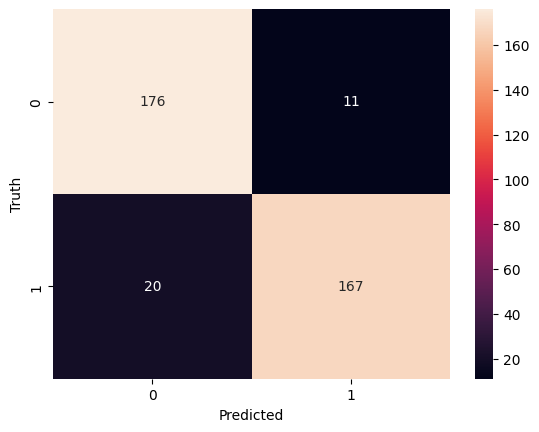

In [54]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [55]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.90      0.94      0.92       187
           1       0.94      0.89      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



### Inference

In [56]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 11s 11s/step


array([[0.7193292 ],
       [0.7850189 ],
       [0.7339078 ],
       [0.18383817],
       [0.09550633]], dtype=float32)

### Save the model

In [ ]:
model.save("/saved_model/2")

In [ ]:
model.save("/saved_model/3")